# Programmierabgabe - Gruppe 10
**Teilnehmer der Gruppe:**
- Bergmann, Jona (2950692)
- Busch, Henrik (...)

Für die Lösung dieser Aufgabe wurde ein `Python 3.11.9 Kernel` verwendet. Alle formalen Anforderungen an diese Prüfungsleistung sind in diesem Jupyter-Notebook vorhanden. Als IDE für die Erstellung des Notebooks wurde `VS Code` auf `Windows 11` genutzt.

Die `Quellen`, die für die Anfertigung dieses Dokuments genutzt worden sind, können am Ende des Notebooks gefunden werden.

## Klassifikation von Objekten in Bildern mit Scikit-Learn
Klassifiziert werden, sollen zehn Objekte des Datensets `CIFAR10`. Die folgenden Objekte nach `[Kri24]` sind:

1. Flugzeug
2. Auto
3. Vogel
4. Katze
5. Reh
6. Hund
7. Frosch
8. Pferd
9. Schiff
10. LKW

### Merkmalsbasierte Klassifikation
Die gestellte Aufgabe dieses Teils der Prüfunsgleistung sieht vor, dass ein `Random Forest (RF)` zur Objekt-Klassifikation genutzt werden soll.

Falls nicht bereits vorhanden, müssen alle benötigten **Python-Module** installiert werden:

In [1]:
pip install numpy scikit-learn scipy opencv-python scikit-image matplotlib

Note: you may need to restart the kernel to use updated packages.


---

#### Laden und Splitten der Daten

Nach dem Importieren der Module beginnt das **Preprocessing** des Datensets. Dazu werden die Daten eingelesen und in `Trainings- und Testdaten` aufgeteilt (vgl. `[Dat24]`). Es soll eine Teilung im Verhältnis von 75:25 vorliegen:

In [2]:
import gc
import cv2
from skimage.feature import hog

import pickle
import numpy as np
import matplotlib.pyplot as plt

# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.feature_selection import RFECV

Funktion zum Laden des Datensatzes `[Kri24]`:

In [3]:
def read_data(files):
    images = None
    for file in files:
        with open(file, 'rb') as fo:
            data_dict = pickle.load(fo, encoding='bytes')
            # Create new dictionary
            if images is None:
                images = data_dict
            # Extend dictionary if more than one input file has to be processed
            else:
                for key in images:
                    if isinstance(data_dict[key], list):
                        images[key].extend(data_dict[key])
                    elif isinstance(data_dict[key], bytes):
                        images[key] += data_dict[key]
                    else:
                        pass
    return images

Aufbereitung der Daten:

In dem `pickle`-Dictionary liegen die Bilder als Numpy-Arrays des Typs `dtype=uint8` vor. Über die Liste des Keys **b'labels'** kann auf die Klasse der zugehörigen Arrays zugegriffen werden. Die Arrays sind als verschachtelte Liste abgespeichert und können über den Key **b'data'** aus dem Dictionary extrahiert werden.

Mit nachfolgender Funktion können die Arrays ihren Klassen zugeordnet werden, um diese danach spezifisch ihrer Klasse in Test- und Trainingsdaten aufzuteilen.

In [4]:
def retransform_data(data_set):
    # Retransform data sets to old format
    images           = {}
    images['labels'] = []
    images['data']   = []
    for i in range(10):
        for arr in data_set[i]:
            images['labels'].append(i)
            images['data'].append(arr)
    return images

def split_data(images):   
    # Init dictionaries for test set and training set
    test_set     = {}       # 25%
    training_set = {}       # 75%

    # Extract relevant data from the dictionary
    labels = images[b'labels']
    data   = images[b'data']

    # Temporary nested list for deviding data by attribute
    temp = [[] for _ in range(10)]

    for attr, arr in zip(labels, data):
        if attr == 0: temp[0].append(arr)
        if attr == 1: temp[1].append(arr)
        if attr == 2: temp[2].append(arr)
        if attr == 3: temp[3].append(arr)
        if attr == 4: temp[4].append(arr)
        if attr == 5: temp[5].append(arr)
        if attr == 6: temp[6].append(arr)
        if attr == 7: temp[7].append(arr)
        if attr == 8: temp[8].append(arr)
        if attr == 9: temp[9].append(arr)

    for i in range(10):
        # Split the array of each attribute
        training_set[i], test_set[i] = train_test_split(temp[i], test_size=0.25)

    training_set = retransform_data(training_set)
    test_set = retransform_data(test_set)

    # Delete unnecessary data
    temp = None
    gc.collect()

    return training_set, test_set

---

#### Extraktion geeigneter Merkmale

Für die Extraktion geeigneter Merkmale muss zunächst die Beschaffenheit der Input-Daten analysiert werden. Als Input dienen Bilddateien, die in Arrays gespeichert sind, die jeweils 3072 Werte enthalten (entsprechend RGB-Pixeln eines 32×32-Bildes).

Aus diesen Daten können folgende Merkmale extrahiert werden:
- Durchschnittswerte der Farbkanäle (r, g und b)
- Standardabweichung der Farbkanäle
- Histogramme der Farbkanäle
- Minima und Maxima der Farbwerte
- Durchschnittliche Kantenstärke
- Durchschnittliche Helligkeit des Bildes
- Kantenorientierungen (Histogram of Oriented Gradients)
- Flächenmerkmale (Größen und Umfänge lassen Rückschlüsse auf die Form ziehen)

Auf Grund der bunten und teilweise unnatürlichen Farben der Bilder, können durch die RGB-Werte schlecht Rückschlüsse auf die zehn Objekte gezogen werden. Es wird erhofft, dass die **Kanten- und Flächeninformationen** die Genauigkeit des Random Forest steigern können.

In [5]:
# Preprocess the pictures
def reshape_images(image_set):
    if isinstance(image_set, list):
        image_set = np.array(image_set)
    images = image_set.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images

def to_grayscale(img):
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return grayscale

# Functions for calculating the features
def get_color_val(img):
    r = img[:, :, 0].flatten()
    g = img[:, :, 1].flatten()
    b = img[:, :, 2].flatten()
    return r, g, b

def calc_mean(r, g, b):
    mean_r = np.mean(r)
    mean_g = np.mean(g)
    mean_b = np.mean(b)
    return mean_r, mean_g, mean_b

def calc_std_deviation(r, g, b):
    std_r = np.std(r)
    std_g = np.std(g)
    std_b = np.std(b)
    return std_r, std_g, std_b

def calc_min_mix(color):
    max_val = np.max(color)
    min_val = np.min(color)
    return min_val, max_val

def calc_histograms(img):
    hist_r = cv2.calcHist([img], [0], None, [8], [0, 256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [8], [0, 256]).flatten()
    hist_b = cv2.calcHist([img], [2], None, [8], [0, 256]).flatten()
    # Normalize histograms
    hist_r /= hist_r.sum()
    hist_g /= hist_g.sum()
    hist_b /= hist_b.sum()
    return hist_r, hist_g, hist_b

def calc_avg_brightness(grayscale):
    avg_brightness = np.mean(grayscale)
    return avg_brightness

def calc_edge_intensity(grayscale):
    # Using Sobel filter for edge detection
    edges = cv2.Sobel(grayscale, cv2.CV_64F, 1, 1, ksize=3)
    edge_intensity = np.mean(np.abs(edges))
    return edge_intensity

def calc_hog(grayscale):    # Histogram of Oriented Gradients
    hog_features = hog(
        grayscale,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )
    return hog_features

def calculate_mean(numbers):
    if len(numbers) == 0:
        return 0
    return sum(numbers) / len(numbers)

def calc_contour_features(grayscale):
    # cv2.findContours needs binary data for processing
    edges = cv2.Canny(grayscale, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    area_list = []
    perimeter_list = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        area_list.append(area)
        perimeter_list.append(perimeter)

    if area_list:
        min_area = min(area_list)
        max_area = max(area_list)
    else:
        min_area = 0
        max_area = 0
    if perimeter_list:
        min_perimeter = min(perimeter_list)
        max_perimeter = max(perimeter_list)
    else:
        min_perimeter = 0
        max_perimeter = 0
    mean_area = calculate_mean(area_list)
    mean_perimeter = calculate_mean(perimeter_list)
    return [min_area, max_area, min_perimeter, max_perimeter, mean_area, mean_perimeter]

**Erstellung der Merkmalsvektoren:**

Die Funktion `create_feature_vec()` ruft alle Funktionen auf, die die einzelnen Bilder auf ihre Merkmale untersuchen. Danach werden alle ermittelten Werte zu dem `Feature-Vektor` zusammengesetzt.

In [6]:
def create_feature_vec(data_set):
    feature_vec = []
    
    shaped_imgs = reshape_images(data_set['data'])
    for label, img in zip(data_set['labels'], shaped_imgs):
        r, g, b = get_color_val(img)
        mean_r, mean_g, mean_b = calc_mean(r, g, b)
        std_r, std_g, std_b = calc_std_deviation(r, g, b)
        r_min, r_max = calc_min_mix(r)
        g_min, g_max = calc_min_mix(g)
        b_min, b_max = calc_min_mix(b)
        hist_r, hist_g, hist_b = calc_histograms(img)
        gray_img = to_grayscale(img)
        avg_brightness = calc_avg_brightness(gray_img)
        edge_intensity = calc_edge_intensity(gray_img)
        hog_features = calc_hog(gray_img)
        cont_values = calc_contour_features(gray_img)

        # Create the final feature vector of each image
        feature_vec.append([label, mean_r, mean_g, mean_b, std_r, std_g, std_b, r_min, r_max,
                           g_min, g_max, b_min, b_max, hist_r, hist_g, hist_b, avg_brightness,
                           edge_intensity, hog_features, cont_values])
    return feature_vec

---

#### Merkmalsreduktion

Für die Merkmalsreduktion soll je eine Methode aus dem Bereich **Merkmalstransformation und -selektion** gewählt werden. Beide Methoden sollen miteinander vergleichen werden. Für beide Methoden ist auch die Anzahl der Bäume `n_estimators` und die Tiefe der Bäume `max_depth` relevant. Diese Größen entscheiden über die Genauigkeit der Berechnungen der Random Forest, aber beeinflussen auch signifikant die Rechendauer des Programms. Da auch schon kleine Forest, die aus 10 bis 100 Bäumen bestehen valide Daten liefern können, sollte hier ein Kompromiss aus Genauigkeit und Programmlaufzeit gefunden werden [Rig17].

##### Merkmalstransformation

Es wurde sich für die `PCA` als Methode entschieden. Bei der `Pricipal Component Analysis` (Hauptkomponentenanalyse) handelt es sich um eine lineare Transformation, die einen höher dimensionalen Vektor auf einen weniger dimensionalen Vektor abbildet. Dadurch können die vorliegenden Daten komprimiert werden. Laut `[Gee24]` handelt es sich bei PCA um die beliebteste Technik der Dimensionsreduzierung. Der ursprüngliche Feature-Vektor wird in diesem Fall auf 95% seiner urprünglichen Größe reduziert.

In [7]:
def separate_attributes(feature_vec):
    labels = [fv[0] for fv in feature_vec]
    features = [np.hstack(fv[1:]) for fv in feature_vec]
    return labels, features

def transform_features(train_vec, test_vec):
    train_lbl, train_feat = separate_attributes(train_vec)
    test_lbl, test_feat = separate_attributes(test_vec)

    # Scale the data
    scaler = StandardScaler()
    train_feat = scaler.fit_transform(train_feat)
    test_feat = scaler.transform(test_feat)

    # PCA with dynamic number of components
    pca = PCA(n_components=0.95)
    train_pca = pca.fit_transform(train_feat)
    test_pca = pca.transform(test_feat)

    # Random Forest with optimized hyperparameters
    pca_model = RandomForestClassifier(
        # n_estimators=500,
        # max_depth=25,
        # random_state=42,
        # n_jobs=-1
        n_estimators=1000,
        max_depth=35,
        max_features='sqrt',
        min_samples_split=7,
        min_samples_leaf=3,
        random_state=42,
        n_jobs = -1
    )
        # n_estimators=500,
        # max_depth=35,
        # max_features='sqrt',
        # min_samples_split=7,
        # min_samples_leaf=3,
        # random_state=42,
        # n_jobs = -1

    pca_model.fit(train_pca, train_lbl)
    pca_predictions = pca_model.predict(test_pca)
    pca_accuracy = accuracy_score(test_lbl, pca_predictions)
    return pca_accuracy

##### Merkmalsselektion

Für die Merkmalsselektion wird `RFECV` (Recursive Feature Elimination with Cross Validation) genutzt. Es nutzt dabei einen Wrapper-Ansatz und berechnet ein Ranking aller Selektoren. Über dieses Ranking wird ein neuer - optimaler - Merkmalsraum erstellt. `[Dat17]` zeigt, dass `RFECV` im Vergleich mit anderen Selektionensverfahren die höchsten Genauigkeiten liefern kann.

In [8]:
def select_features(train_vec, test_vec):
    train_lbl, train_feat = separate_attributes(train_vec)
    test_lbl, test_feat = separate_attributes(test_vec)

    scaler = StandardScaler()
    train_feat = scaler.fit_transform(train_feat)
    test_feat = scaler.transform(test_feat)



    param_grid = {
        'n_estimators': [500, 700, 1000],
        'max_depth': [25, 35, 50],
        'min_samples_split': [5, 7, 10],
        'min_samples_leaf': [2, 3, 5],
        'max_features': ['sqrt', 'log2']
    }

    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid=param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1
    )

    grid_search.fit(train_feat, train_lbl)
    best_params = grid_search.best_params_

    rf_estimator = RandomForestClassifier(
        **best_params,
        random_state=42,
        n_jobs = -1
    )
    #     rf_estimator = RandomForestClassifier(
    #     # n_estimators=500,
    #     # max_depth=15,
    #     # max_features='sqrt',
    #     # min_samples_split=5,
    #     # min_samples_leaf=2,
    #     # random_state=42,
    #     # n_jobs = -1
    #     # n_estimators=500,
    #     # max_depth=35,
    #     # max_features='sqrt',
    #     # min_samples_split=7,
    #     # min_samples_leaf=3,
    #     random_state=42,
    #     n_jobs = -1
    # )
        # n_estimators=500,
        # max_depth=35,
        # max_features='sqrt',
        # min_samples_split=7,
        # min_samples_leaf=3,
        # random_state=42,
        # n_jobs = -1
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Recursive Feature Elimination with Cross-Validation
    rfecv = RFECV(
        estimator=rf_estimator,
        step=5,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )

    rfecv.fit(train_feat, train_lbl)

    # Transform both data sets to extract features
    train_feat_reduced = rfecv.transform(train_feat)
    test_feat_reduced = rfecv.transform(test_feat)

    # Train a Random Forest with reduced data set
    rf_estimator.fit(train_feat_reduced, train_lbl)

    test_predictions = rf_estimator.predict(test_feat_reduced)
    accuracy = accuracy_score(test_lbl, test_predictions)
    return accuracy

---
#### Random-Forest-Klassifikator

Damit der `Random Forest` die Objekte auf den Bildern möglichst präzise klassifizieren kann, wird auf das sogenannte `Hyperparameter Tuning` zurückgegriffen. Dabei wird dem Classifier ein Parameter-Grid übergeben, aus dem er verschiedene Klassifizierungen vornehmen kann. Nachfolgend ist der Classifier in der Lage die Ergebnisse zu vergleichen und einen Report zu erstellen. Auf diese Weise kann der Data Scientist per trail-and-error-Verfahren versuchen die optimalen Parameter für den `Random Forest` zu finden `[Tow24]`.

In [9]:
def hyperparameter_optimization(train_vec, test_vec):
    train_lbl, train_feat = separate_attributes(train_vec)
    test_lbl, test_feat = separate_attributes(test_vec)

    scaler = StandardScaler()
    train_feat = scaler.fit_transform(train_feat)
    test_feat = scaler.transform(test_feat)

    rf = RandomForestClassifier(random_state=42)

    # Define hyperparameter grid
    param_grid = {
    #     'n_estimators': [580, 600, 620],
    #     'max_depth': [13, 14, 15],
    #     'min_samples_split': [7, 8, 9],
    #     'min_samples_leaf': [2, 3, 4],
    #     'max_features': ['sqrt']
        'n_estimators': [100, 1500, 2000],
        'max_depth': [5, 15, 55, 65],
        'min_samples_split': [3, 13, 15],
        'min_samples_leaf': [2, 4, 8, 10],
        'max_features': ['sqrt']
    }

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(train_feat, train_lbl)

    # Best modell and best parameter
    best_rf = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluation of the test data set
    lbl_pred = best_rf.predict(test_feat)
    accuracy = accuracy_score(test_lbl, lbl_pred)

    return best_params, accuracy, classification_report(test_lbl, lbl_pred)

---

#### Evaluation mit dreifacher Kreuzvalidierung

Abschließend werden die Ergebnisse des `Random Forests` untersucht. Um Overfitting auszuschließen, wird mit der Kreuzvalidierung gearbeitet.
- `Overfitting` bedeutet, dass das Modell zwar gut auf die Trainingsdaten reagiert, aber schlecht mit Testdaten performt.
- Bei der `Kreuzvalidierung` werden die Daten in kleinere Subsets aufgebrochen und iterativ miteinander als Test- und Trainingsdaten getauscht. So erfährt das Modell viele Konstellationen an Trainings- und Testdaten und kann im Anschluss effektiver auf fremde Datensätze reagieren [Tow24].

In [10]:
def evaluation_3cv(best_params, feat_vec):
    train_lbl, train_feat = separate_attributes(feat_vec)
    best_rf = RandomForestClassifier(**best_params, random_state=42)
    cv_scores = cross_val_score(best_rf, train_feat, train_lbl, cv=3, scoring='accuracy')
    return best_rf, cv_scores

---
**Beachte**, dass die Dateipfade angepasst werden müssen! Es kann für Testzwecke auch nur eine der sechs Datensätze genutzt werden. Doch auch bei der Verwendung von nur einem Dateipfad muss dieser in einer `Liste` vorliegen, um vom Skript fehlerfrei verarbeitet werden zu können.

In [11]:
files = [
    "/home/server/Code/UniCode/ML/cifar-10-batches-py/test_batch",
    "/home/server/Code/UniCode/ML/cifar-10-batches-py/data_batch_1",
    "/home/server/Code/UniCode/ML/cifar-10-batches-py/data_batch_2",
    "/home/server/Code/UniCode/ML/cifar-10-batches-py/data_batch_3",
    "/home/server/Code/UniCode/ML/cifar-10-batches-py/data_batch_4",
    "/home/server/Code/UniCode/ML/cifar-10-batches-py/data_batch_5"
]


images = read_data(files)

train_set, test_set = split_data(images)

train_feat_vec = create_feature_vec(train_set)
test_feat_vec  = create_feature_vec(test_set)

In [12]:
pca_accuracy   = transform_features(train_feat_vec, test_feat_vec)

In [13]:
rfecv_accuracy = select_features(train_feat_vec, test_feat_vec)

/home/server/Code/UniCode/ML/.ml/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [14]:
best_params, hpo_accuracy, report = hyperparameter_optimization(train_feat_vec, test_feat_vec)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


/home/server/Code/UniCode/ML/.ml/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/server/Code/UniCode/ML/.ml/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [15]:
feat_vec = train_feat_vec + test_feat_vec

best_rf, cv_scores = evaluation_3cv(best_params, feat_vec)

print(f"\n\nAccuracy:\nPCA: {pca_accuracy} <-> RFECV: {rfecv_accuracy}\n")
print(f"Best Hyperparameter: {best_params}")
print(f"Accuracy: {hpo_accuracy}")
print(f"Classification Report: {report}\n")
print(f"Cross validation Accuracy: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores)}")
print(f"Standard deviation of the Accuracy: {np.std(cv_scores)}")



Accuracy:
PCA: 0.4876 <-> RFECV: 0.5164

Best Hyperparameter: {'max_depth': 55, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 2000}
Accuracy: 0.5224
Classification Report:               precision    recall  f1-score   support

           0       0.58      0.59      0.58       250
           1       0.58      0.69      0.63       250
           2       0.53      0.31      0.39       250
           3       0.38      0.18      0.25       250
           4       0.44      0.50      0.47       250
           5       0.42      0.53      0.47       250
           6       0.54      0.62      0.58       250
           7       0.58      0.53      0.55       250
           8       0.56      0.59      0.57       250
           9       0.57      0.68      0.62       250

    accuracy                           0.52      2500
   macro avg       0.52      0.52      0.51      2500
weighted avg       0.52      0.52      0.51      2500


Cross validation Accuracy

#### Konfusionsmatrix

Die `Konfusionsmatrix` stellt die Vorhersage des Modells der richtigen Vorhersage gegenüber. Daran kann der Zusammenhang zwischen falsch-positiven (oben rechts) und falsch-negativen (unten links) erkannt werden `[Dat24]`.

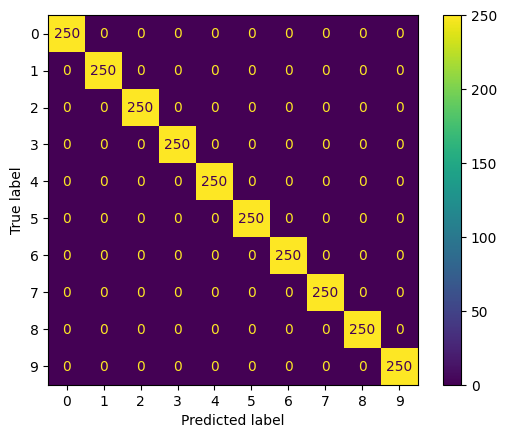

In [16]:
test_lbl, test_feat = separate_attributes(test_feat_vec)
best_rf.fit(test_feat, test_lbl)

# Generate predictions with the best model
y_pred = best_rf.predict(test_feat)

# Create the confusion matrix
cm = confusion_matrix(test_lbl, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

#### Feature Importance

Der unten dargestellte Graph beschreibt die Relevanz der einzelnen Features, die dem berechneten Feature-Vektor inneliegen. Je größer der Ausschlag des Indexes, desto mehr trägt das Feature zur Merkmalserkennung bei.

| Farbmerkmal | mean_r    | mean_g    | mean_b    | std_r     | std_g     | std_b     |
|:-----------:|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|
| **Index**   | 1         | 2         | 3         | 4         | 5         | 6         |

</br>

| Farbmerkmal | r_min     | r_max     | g_min     | g_max     | b_min     | b_max     |
|:-----------:|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|
| **Index**   | 7         | 8         | 9         | 10        | 11        | 12        |

</br>

| Farbmerkmal | hist_r    | hist_g    | hist_b    | avg_brightness |
|:-----------:|:---------:|:---------:|:---------:|:---------:|
| **Index**   | 13 - 20   | 21 - 28   | 29 - 36   | 37        |

</br>

| Formmerkmal | edge_intensity | hog_features | cont_values |
|:-----------:|:---------:|:---------:|:---------:|
| **Index**   | 38        | 39 - 362  | 363 - 368 |


Top 10 Indices:

Index: 37, Importance: 0.010343929884048647
Index: 5, Importance: 0.008836596207149978
Index: 34, Importance: 0.006720565762272797
Index: 2, Importance: 0.006323575279553174
Index: 11, Importance: 0.006129678107627069
Index: 35, Importance: 0.005966804096834199
Index: 4, Importance: 0.00591687486000319
Index: 303, Importance: 0.005428525849571204
Index: 213, Importance: 0.005037488322417244
Index: 33, Importance: 0.0049755890898667285

Relevant color features: 8
Relevant shape features: 2



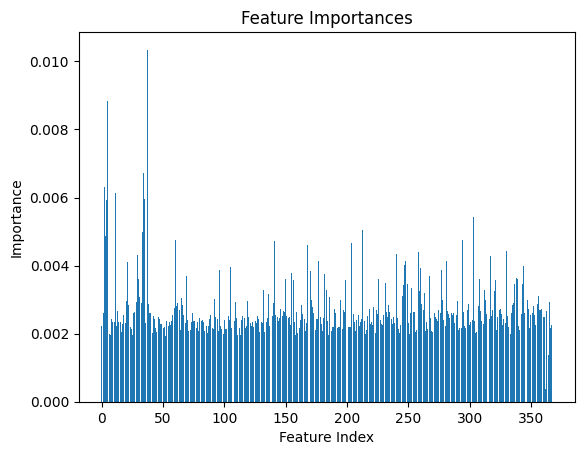

In [17]:
importance = best_rf.feature_importances_

# Find the indices with the top 10 values
arr = np.array(importance)
top_10_indices = np.argpartition(arr, -10)[-10:]
top_10_sorted = sorted([(idx, arr[idx]) for idx in top_10_indices], key=lambda x: x[1], reverse=True)

print("Top 10 Indices:\n")
color = 0
shape = 0
for idx, value in top_10_sorted:
    print(f"Index: {idx}, Importance: {value}")
    if idx < 38:
        color += 1
    else:
        shape += 1
print(f"\nRelevant color features: {color}\nRelevant shape features: {shape}\n")

plt.bar(range(len(importance)), importance)
plt.xlabel("Feature Index")
plt.ylabel("Importance")    
plt.title("Feature Importances")
plt.show()

---

### Fazit

Alle Ergebnisse wurden mit einem *reduzierten Datensatz* ermittelt, um die benötigte Rechenleistung und -dauer zu reduzieren.

#### Vergleich von PCA und RFECV

Bei der Nutzung aller Merkmale (Farb + Kantenmerkmale) und einer **Baumanzahl von 300** mit einer **maximalen Tiefe von 15** bei `PCA` und `RFECV` sind die Ergebnisse von `RFECV` besser (0.47 zu 0.5). Bei `RFECV` wurde eine **Kreuzvalidierung von 3** genutzt. Dieser kaum besseren Performance steht wiederum ein **Zeitaufwand** von **21.2s** für `PCA` und **947m 32.9s** für `RFECV` entgegen. Wird die Anzahl der Bäume für `PCA` auf 1000 erhöht, wird ebenfalls eine Genauigkeit von 50% erreicht. Die Programmlaufzeit des PCA-Algorithmus liegt hier bei **1m 43.6s**. Eine weitere Erhöhung der Baumanzahl führt zu einer weniger relevanten Verbesserung der Genauigkeit im Vergleich zum Zuwachs der Programmlaufzeit.

#### Vergleich der Merkmale

Beim Durchlaufen der ersten Programmentwürfe, die hauptsächlich auf Farbmerkmalen und kleinen Bäumen basierten, konnten innerhalb von 5 Minuten alle Skripte durchlaufen werden. Erreicht wurden - je nach Random Forest - zwischen `30%` und `35%` Genauigkeit. Genutzt wurde nur einer der sechs Datensets. Nach den Anpassungen der RFs und einer umfangreicheren hyperparametrischen Optimierung konnten Genauigkeiten bis zu `40%` erzielt werden. Danach wurden weitere geometrische Merkmale erarbeitet und dem Code hinzugefügt, diese führten zu einem hohen zeitlichen Mehraufwand. Die Ergebnisse und die Gegenüberstellung sind unten aufgeführt.

**Genutzt wurde auf Grund seiner Geschwindigkeit das PCA-Verfahren:**
- `Anzahl der Bäume`: 500
- `Maximale Tiefe`: 15

Bei den Werten handelt es sich um Mittelwerte. Es wurde jeder Test fünf mal durchgeführt.

| Merkmal     | Laufzeit    | Genauigkeit |
|:-----------:|:-----------:|:-----------:|
| **Farbe**   | 13.62s      | 0.3238      |
| **Form**    | 34.04s      | 0.4730      |
| **Gesamt**  | 34.60s      | 0.4865      |

**Farbmerkmale:**
- `mean_r`, `mean_g`, `mean_b`
- `std_r`, `std_g`, `std_b`
- `r_min`, `r_max`, `g_min`, `g_max`, `b_min`, `b_max`
- `hist_r`, `hist_g`, `hist_b`
- `avg_brightness`

**Formmerkmale:**
- `edge_intensity`
- `hog_features`
- `cont_values`

#### Die besten Parameter für die Merkmalsklassifikation

Nach dem Durchführen von mehreren Test mit der hyperparametrischen Optimierung haben sich folgende Parameter als optimal herausgestellt:
- `n_estimators`: 600
- `max_depth`: 14
- `min_samples_split`: 7
- `min_samples_leaf`: 2
- `max_features`: sqrt

Erwähnenswert ist, dass nicht jeder Durchlauf das exkat gleiche Ergebnis bringt, sodass nach der Optimierung auch andere Werte vorgeschlagen werden können.

---

### Benutzte Quellen:

`[Dat17]` Data Science Blog. Der Blick für das Wesentliche: Die Merkmalsselektion. Accessed: 2024-11-28. 2017. url: https://data-science-blog.com/blog/2017/03/30/der-blick-fur-das-wesentliche-die-merkmalsselektion/.

`[Dat24]` DataCamp. Random Forests Classifier in Python. Accessed: 2024-11-27. 2024. url: https://www.datacamp.com/tutorial/random-forests-classifier-python.

`[Gee24]` GeeksforGeeks. Principal Component Analysis (PCA). Accessed: 2024-11-28. 2024. url: https://www.geeksforgeeks.org/principal-component-analysis-pca/.

`[Kri24]` Alex Krizhevsky. The CIFAR-10 and CIFAR-100 Datasets. Accessed: 2024-11-27. 2024. url: https://www.cs.toronto.edu/~kriz/cifar.html.

`[Rig17]` Steven J Rigatti. “Random forest”. In: Journal of Insurance Medicine 47.1 (2017), S. 31–39.

`[Tow24]` Towards Data Science. Hyperparameter Tuning the Random Forest in Python using Scikit-Learn. Accessed: 2024-11-02. 2024. url: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74.